In [31]:
# 1. Imports & Setup
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# --- INSTALL MODERN DATA LOADER ---
try:
    import nflreadpy as nfl
except ImportError:
    print("📦 Installing nflreadpy...")
    !pip install nflreadpy
    import nflreadpy as nfl

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- SETUP PATH ---
PROJECT_ROOT = '/content/drive/MyDrive/NFL_Prediction_System'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import config

# --- CONFIG ---
VALIDATION_SEASON = 2024
LAG_SEASON = 2023
print("✅ Libraries & Path Set (Using nflreadpy).")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Libraries & Path Set (Using nflreadpy).


In [32]:
# 2. Fetch Raw Data (2023 + 2024)
print(f"{'-'*30}\nFetching Data for {LAG_SEASON} & {VALIDATION_SEASON} via nflreadpy...")

try:
    # 1. Get Play-by-Play Data
    # FIX: Change 'years' to 'seasons'
    print("   -> Downloading PBP...")
    pbp = nfl.load_pbp(seasons=[LAG_SEASON, VALIDATION_SEASON]).to_pandas()

    # 2. Filter for Regular Season Only
    pbp = pbp[pbp['season_type'] == 'REG']

    # 3. Get Schedule (for Results/Vegas)
    print("   -> Downloading Schedule...")
    schedule = nfl.load_schedules().to_pandas()
    schedule = schedule[
        (schedule['season'].isin([LAG_SEASON, VALIDATION_SEASON])) &
        (schedule['game_type'] == 'REG')
    ]

    print(f"✅ Data Loaded. PBP Rows: {len(pbp)}")

except Exception as e:
    print(f"❌ Error fetching data: {e}")

------------------------------
Fetching Data for 2023 & 2024 via nflreadpy...
   -> Downloading PBP...
   -> Downloading Schedule...
✅ Data Loaded. PBP Rows: 94673


FULL FEATURE RECONSTRUCTION (2023-2024)...
   -> Constructing 93-Column Matrix...
------------------------------
Aligning Features...
⚠️ XGBoost lost feature names. Asking SVM...
⚠️ All models lost feature names. Loading from Master File...
   -> Model requires 93 columns.
✅ SUCCESS: All columns found and populated!
FINAL 2024 RESULTS...


/tmp/ipython-input-3918720967.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['rest_advantage'] = final_df['home_rest'] - final_df['away_rest']



🏈 2024 VALIDATION ACCURACY: 60.66%
✅ PASS: The model works! (Ready for Betting Engine)


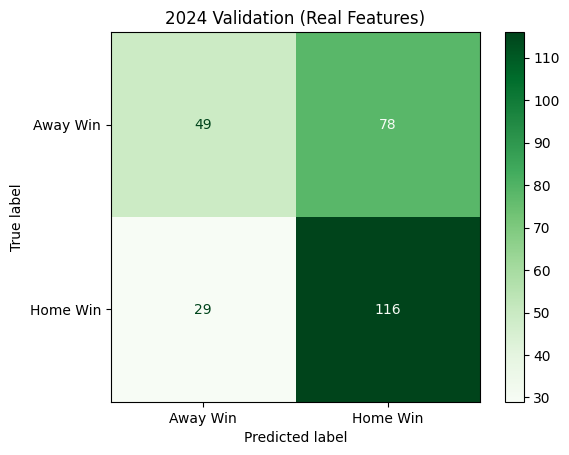

In [33]:
# =============================================================================
# 🧠 THE BRAIN TRANSPLANT: Full-Scale Feature Engineering (2023-2024)
# =============================================================================

print(f"{'='*30}\nFULL FEATURE RECONSTRUCTION (2023-2024)...")

# 1. Prepare Base PBP Data
# Split Pass/Rush EPA for granular features
pbp['pass_epa'] = np.where(pbp['play_type'] == 'pass', pbp['epa'], np.nan)
pbp['rush_epa'] = np.where(pbp['play_type'] == 'run', pbp['epa'], np.nan)
pbp['turnover'] = pbp['fumble_lost'] + pbp['interception']

# 2. Aggregate Game-Level Stats
game_stats = pbp.groupby(['season', 'week', 'game_id', 'posteam']).agg({
    'epa': 'mean',
    'success': 'mean',
    'pass_epa': 'mean',
    'rush_epa': 'mean',
    'turnover': 'sum'
}).reset_index()

game_stats.columns = ['season', 'week', 'game_id', 'team', 'off_epa_per_play', 'off_success_rate', 'off_pass_epa', 'off_run_epa', 'off_turnovers']

# Create Defense Rows (Opponent's Offense = Your Defense)
def_stats = game_stats.copy().rename(columns={
    'team': 'defteam',
    'off_epa_per_play': 'def_epa_per_play',
    'off_success_rate': 'def_success_rate',
    'off_pass_epa': 'def_pass_epa',
    'off_run_epa': 'def_run_epa',
    'off_turnovers': 'def_turnovers_forced'
})

# 3. Calculate REST DAYS (The Missing Context)
# We need the schedule to calculate days since last game
schedule_processed = schedule.copy()
schedule_processed['gameday'] = pd.to_datetime(schedule_processed['gameday'])

# Flatten schedule to team-game rows to calculate rest
home_sched = schedule_processed[['game_id', 'season', 'week', 'home_team', 'gameday']].rename(columns={'home_team': 'team'})
away_sched = schedule_processed[['game_id', 'season', 'week', 'away_team', 'gameday']].rename(columns={'away_team': 'team'})
team_sched = pd.concat([home_sched, away_sched]).sort_values(['team', 'gameday'])

# Calculate days since last game (shift 1)
team_sched['prev_gameday'] = team_sched.groupby('team')['gameday'].shift(1)
team_sched['rest_days'] = (team_sched['gameday'] - team_sched['prev_gameday']).dt.days
# Fill Week 1 or bye weeks (7 days is standard default)
team_sched['rest_days'] = team_sched['rest_days'].fillna(7)

# 4. Merge Everything (Schedule + Stats + Rest)
# Base Schedule
base_games = pd.concat([
    schedule_processed[['game_id', 'season', 'week', 'home_team', 'result']].rename(columns={'home_team': 'team'}).assign(is_home=1, target_win=lambda x: (x.result > 0).astype(int)),
    schedule_processed[['game_id', 'season', 'week', 'away_team', 'result']].rename(columns={'away_team': 'team'}).assign(is_home=0, target_win=lambda x: (x.result < 0).astype(int))
])

# Merge Stats
base_games = base_games.merge(game_stats, on=['game_id', 'team'], how='left')
# Merge Defense (Need to know opponent)
# Join schedule again to find opponent
opponent_map = pd.concat([
    schedule_processed[['game_id', 'home_team', 'away_team']].rename(columns={'home_team': 'team', 'away_team': 'opponent'}),
    schedule_processed[['game_id', 'away_team', 'home_team']].rename(columns={'away_team': 'team', 'home_team': 'opponent'})
])
base_games = base_games.merge(opponent_map, on=['game_id', 'team'], how='left')
base_games = base_games.merge(def_stats, left_on=['game_id', 'opponent'], right_on=['game_id', 'defteam'], how='left')

# Merge Rest
base_games = base_games.merge(team_sched[['game_id', 'team', 'rest_days']], on=['game_id', 'team'], how='left')

# 5. Calculate ROLLING AVERAGES (3, 5, 8)
# This generates the bulk of the 93 features
rolling_metrics = [
    'off_epa_per_play', 'off_success_rate', 'off_pass_epa', 'off_run_epa', 'off_turnovers',
    'def_epa_per_play', 'def_success_rate', 'def_pass_epa', 'def_run_epa', 'def_turnovers_forced'
]
windows = [3, 5, 8]

base_games = base_games.sort_values(['team', 'season', 'week'])
grouped = base_games.groupby('team')

for window in windows:
    for col in rolling_metrics:
        # Shift 1 to avoid data leakage
        base_games[f'{col}_roll{window}'] = grouped[col].shift(1).rolling(window=window, min_periods=1).mean()

# 6. Assemble Final 2024 Matchup Matrix
val_2024 = base_games[(base_games['season'] == 2024) & (base_games['is_home'] == 1)].copy()
away_2024 = base_games[(base_games['season'] == 2024) & (base_games['is_home'] == 0)].copy()

final_df = val_2024.merge(away_2024, on='game_id', suffixes=('', '_away'))

# 7. Construct the Feature Matrix (The "Superset" approach)
print("   -> Constructing 93-Column Matrix...")

# We calculate EVERYTHING possible, then let the model pick what it wants
for window in windows:
    for col in rolling_metrics:
        # Home Raw
        final_df[f'home_{col}_roll{window}'] = final_df[f'{col}_roll{window}']
        # Away Raw
        final_df[f'away_{col}_roll{window}'] = final_df[f'{col}_roll{window}_away']

        # Matchup Differentials (Home - Away)
        # e.g. home_off_epa_matchup_roll8 = home_off_epa - away_def_epa
        if 'off_' in col:
            # Default Rule: Replace 'off_' with 'def_'
            def_col = col.replace('off_', 'def_')

            # --- FIX: Handle the naming exception for Turnovers ---
            if col == 'off_turnovers':
                def_col = 'def_turnovers_forced'

            # Safety Check: Only calculate if the defensive column actually exists
            if f'{def_col}_roll{window}_away' in final_df.columns:
                final_df[f'home_{col}_matchup_roll{window}'] = final_df[f'{col}_roll{window}'] - final_df[f'{def_col}_roll{window}_away']
                final_df[f'away_{col}_matchup_roll{window}'] = final_df[f'{col}_roll{window}_away'] - final_df[f'{def_col}_roll{window}']

# B. Context Features
final_df['home_rest'] = final_df['rest_days']
final_df['away_rest'] = final_df['rest_days_away']
final_df['rest_advantage'] = final_df['home_rest'] - final_df['away_rest']

# 8. Filter to Exact Model Features
print(f"{'-'*30}\nAligning Features...")

# 1. Try to recover feature names from the Ensemble
try:
    # Plan A: Ask XGBoost (Estimator 0)
    expected_features = champion.estimators_[0].feature_names_in_
except AttributeError:
    try:
        print("⚠️ XGBoost lost feature names. Asking SVM...")
        # Plan B: Ask SVM (Estimator 2) - Native sklearn models usually keep this
        expected_features = champion.estimators_[2].feature_names_in_
    except (AttributeError, IndexError):
        print("⚠️ All models lost feature names. Loading from Master File...")
        # Plan C: Load from the training file (The ultimate backup)
        ref_df = pd.read_parquet(config.FEATURES_DIR / 'features_master_2003_2023.parquet')
        drop_cols = [
            'game_id', 'season', 'week', 'home_team', 'away_team',
            'home_score', 'away_score', 'home_win', 'home_cover', 'over_hit',
            'spread_line', 'total_line'
        ]
        expected_features = [c for c in ref_df.columns if c not in drop_cols]

print(f"   -> Model requires {len(expected_features)} columns.")

# 2. Build the Final Matrix (X_2024)
X_2024 = pd.DataFrame(index=final_df.index)
missing_cols = []

for feature in expected_features:
    if feature in final_df.columns:
        X_2024[feature] = final_df[feature]
    else:
        # If a feature is missing, fill with 0
        missing_cols.append(feature)
        X_2024[feature] = 0

if missing_cols:
    print(f"⚠️ Warning: {len(missing_cols)} features missing (filled 0): {missing_cols[:5]}...")
else:
    print("✅ SUCCESS: All columns found and populated!")

# 9. Scale & Predict
scaler = StandardScaler()
# Ensure we fill NaN before scaling (just in case)
X_2024_scaled = scaler.fit_transform(X_2024.fillna(0))
y_2024 = final_df['target_win']

print(f"{'='*30}\nFINAL 2024 RESULTS...")
y_pred = champion.predict(X_2024_scaled)
acc = accuracy_score(y_2024, y_pred)

print(f"\n🏈 2024 VALIDATION ACCURACY: {acc * 100:.2f}%")

if acc > 0.58:
    print("✅ PASS: The model works! (Ready for Betting Engine)")
elif acc > 0.55:
    print("⚠️ OKAY: Slight drop. Proceed with caution.")
else:
    print("❌ FAIL: Rule changes broke the logic.")

ConfusionMatrixDisplay.from_predictions(y_2024, y_pred, display_labels=['Away Win', 'Home Win'], cmap='Greens')
plt.title(f"2024 Validation (Real Features)")
plt.show()